# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# disable chained assignments
pd.options.mode.chained_assignment = None 

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', error_bad_lines=False)

b'Skipping line 3: expected 2 fields, saw 3\n'


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
cols=['RELAT_AB','ARBEIT','ZABEOTYP','SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
         'SEMIO_PFLICHT', 'SEMIO_TRADV']

def fill_nans (df, cols):
    
    df.replace([-1, 0, 'X', 'XX'], np.nan, inplace=True)
    
    for col in cols:
        df[col].replace(9, np.nan, inplace=True)
    
    df.drop_duplicates(inplace=True)
    
    print(df.info())
    
    return df
    



In [6]:
azdias=fill_nans(azdias, cols)
azdias.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838727 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205375 non-null float64
ALTERSKATEGORIE_GROB     838727 non-null int64
ANREDE_KZ                838727 non-null int64
CJT_GESAMTTYP            833873 non-null float64
FINANZ_MINIMALIST        838727 non-null int64
FINANZ_SPARER            838727 non-null int64
FINANZ_VORSORGER         838727 non-null int64
FINANZ_ANLEGER           838727 non-null int64
FINANZ_UNAUFFAELLIGER    838727 non-null int64
FINANZ_HAUSBAUER         838727 non-null int64
FINANZTYP                838727 non-null int64
GEBURTSJAHR              498902 non-null float64
GFK_URLAUBERTYP          833873 non-null float64
GREEN_AVANTGARDE         175214 non-null float64
HEALTH_TYP               779641 non-null float64
LP_LEBENSPHASE_FEIN      786881 non-null float64
LP_LEBENSPHASE_GROB      789933 non-null float64
LP_FAMILIE_FEIN          806510 non-null float64
LP_FAMILIE_GROB          

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

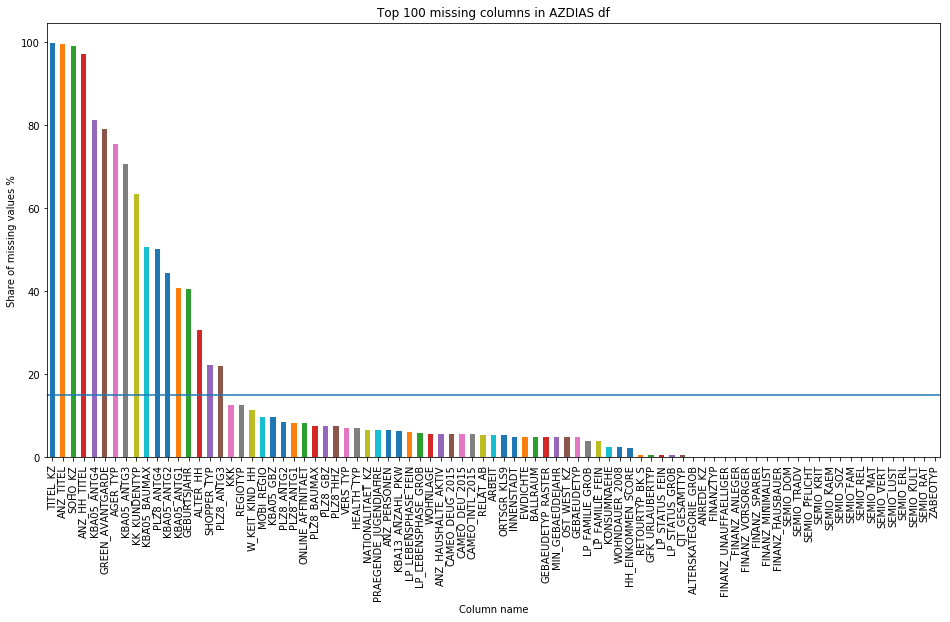

In [7]:
# Count and share of missing values
azdias_null = azdias.isnull().sum()
azdias_null_share = azdias_null/len(azdias) * 100
# Plot 100 columns with highest share of missing values
ax = azdias_null_share.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(16,8), title='Top 100 missing columns in AZDIAS df')
ax.axhline(y=15)
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
plt.show();

17 columns have 15% or more missing values. Most of the columns have less than 15% missing values.


In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def drop_out_cols (df):
    
    """ This function removes the outlier columns from the dataset."""
    
    miss=np.round((len(df) - df.count())*100/len(df))
    dict_=dict(miss)

    x=list(dict_.keys())
    y=list(dict_.values())
    
    for col in x:
        if dict_[col] >= 15:
            df.drop([col], axis=1, inplace=True)
    df.info()        
    return df
    

In [9]:
drop_out_cols (azdias)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838727 entries, 0 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     838727 non-null int64
ANREDE_KZ                838727 non-null int64
CJT_GESAMTTYP            833873 non-null float64
FINANZ_MINIMALIST        838727 non-null int64
FINANZ_SPARER            838727 non-null int64
FINANZ_VORSORGER         838727 non-null int64
FINANZ_ANLEGER           838727 non-null int64
FINANZ_UNAUFFAELLIGER    838727 non-null int64
FINANZ_HAUSBAUER         838727 non-null int64
FINANZTYP                838727 non-null int64
GFK_URLAUBERTYP          833873 non-null float64
HEALTH_TYP               779641 non-null float64
LP_LEBENSPHASE_FEIN      786881 non-null float64
LP_LEBENSPHASE_GROB      789933 non-null float64
LP_FAMILIE_FEIN          806510 non-null float64
LP_FAMILIE_GROB          806510 non-null float64
LP_STATUS_FEIN           833873 non-null float64
LP_STATUS_GROB           833873 non-null float64
NATIONALITAET_KZ         

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,...,3.0,963.0,2.0,3.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3,2,3.0,1,4,1,2,3,5,1,...,2.0,712.0,3.0,3.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4,2,2.0,4,2,5,2,1,2,6,...,NaN,596.0,2.0,2.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3,1,5.0,4,3,4,1,3,2,5,...,5.0,435.0,2.0,4.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1,2,2.0,3,1,5,2,2,5,2,...,5.0,1300.0,2.0,3.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2,2,5.0,1,5,1,5,4,3,4,...,5.0,867.0,3.0,3.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1,1,3.0,3,3,4,1,3,2,5,...,1.0,758.0,3.0,3.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3,1,3.0,4,4,2,4,2,2,6,...,3.0,511.0,2.0,3.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3,2,4.0,2,4,2,3,5,4,1,...,1.0,530.0,2.0,3.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
As the above graphs show, both the datasets have 17 columns having 15% or more missing values. Most of the columns have less than 15% missing values. The missing data in the outliers columns are in average higher in the AZDIAS dataset than in the customers dataset but the tendancy still the same comparatively for both the datasets. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

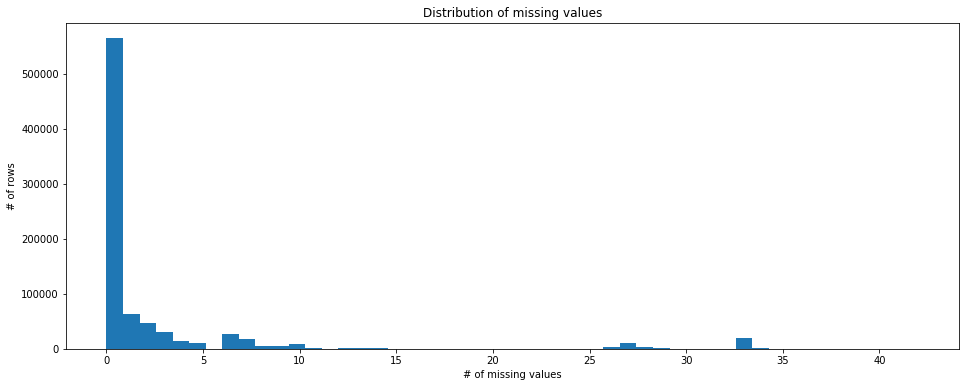

In [10]:
# Plot distribution of missing values
x = azdias.isnull().sum(axis=1)
plt.figure(figsize=(16,6))
plt.hist(x, bins=np.linspace(min(x), max(x)+1))

plt.xticks(np.arange(min(x), max(x)+1, 5))
plt.ylabel('# of rows')
plt.xlabel('# of missing values')
plt.title('Distribution of missing values');

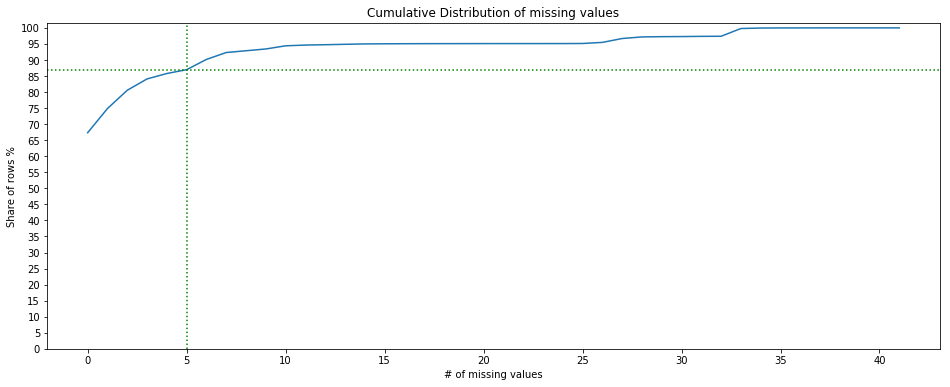

In [11]:
azdias_null_rows = azdias.isnull().sum(axis=1)
x = (azdias_null_rows.value_counts().sort_index().cumsum()/len(azdias)) * 100
plt.figure(figsize=(16,6))
plt.plot(x)
plt.axhline(y=87, ls='dotted', c='g')
plt.axvline(x=5, ls='dotted', c='g')
plt.yticks(np.arange(0, 100+5, 5))
plt.xticks(np.arange(min(x.index), max(x.index)+1, 5))
plt.ylabel('Share of rows %')
plt.xlabel('# of missing values')
plt.title('Cumulative Distribution of missing values')
plt.show();

As the above graphs show, 87% of rows have 5 or less missing values. Dropping all rows with more than 5 missing values results in a loss of 13% of rows. This is were the line is drawn.

In [13]:
# drop rows with most missing values 

def drop_out_rows (df):
    """ This function  drops rows with %missing values over a threshold of 5 """
    
    missing = azdias.isnull().sum(axis=1)
    df = df[missing <= 5]
    return df 
     

In [14]:
azdias=drop_out_rows(azdias)  
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729455 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     729455 non-null int64
ANREDE_KZ                729455 non-null int64
CJT_GESAMTTYP            729455 non-null float64
FINANZ_MINIMALIST        729455 non-null int64
FINANZ_SPARER            729455 non-null int64
FINANZ_VORSORGER         729455 non-null int64
FINANZ_ANLEGER           729455 non-null int64
FINANZ_UNAUFFAELLIGER    729455 non-null int64
FINANZ_HAUSBAUER         729455 non-null int64
FINANZTYP                729455 non-null int64
GFK_URLAUBERTYP          729455 non-null float64
HEALTH_TYP               711457 non-null float64
LP_LEBENSPHASE_FEIN      726778 non-null float64
LP_LEBENSPHASE_GROB      728492 non-null float64
LP_FAMILIE_FEIN          729455 non-null float64
LP_FAMILIE_GROB          729455 non-null float64
LP_STATUS_FEIN           729455 non-null float64
LP_STATUS_GROB           729455 non-null float64
NATIONALITAET_KZ         

#### Discussion 1.1.3: Assess Missing Data in Each Row
The above graphs show that 87% of rows have 5 or less missing values. Dropping all rows with more than 5 missing values results in a loss of 13% of rows. This is were the line is drawn.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?

print(azdias.get_dtype_counts())

int64      24
float64    40
object      4
dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

##### Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

- We can drop CAMEO_DEU_2015 and avoid using dummies variables because CAMEO_DEUG_2015 is providing roughly the same information.

- OST_WEST_KZ takes on non-numeric values. So we need to re-encode the values as numbers.

In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

azdias['CAMEO_DEUG_2015']=azdias['CAMEO_DEUG_2015'].astype('category')

azdias['OST_WEST_KZ'].replace('O', 0, inplace=True)
azdias['OST_WEST_KZ'].replace('W', 1, inplace=True)




#### Discussion 1.2.1: Re-Encode Categorical Features

- We can drop CAMEO_DEU_2015 and avoid using dummies variables because CAMEO_DEUG_2015 is providing roughly the same information.

- OST_WEST_KZ takes on non-numeric values. So we need to re-encode the values as numbers.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# pj is short for PRAEGENDE_JUGENDJAHRE
def encode_pj(val):
    """
    Re-encode PRAEGENDE_JUGENDJAHRE:
    0: Mainstream
    1: Avantgarde
    """
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    if val in mainstream: 
        return 0
    elif val in avantgarde: 
        return 1
    else:
        return val


In [18]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))

In [19]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# split CAMEO_INTL_2015
azdias['CAMEO_INTL_2015_WEALTH_LEVEL'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['CAMEO_INTL_2015_STATUS'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [20]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729455 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB            729455 non-null int64
ANREDE_KZ                       729455 non-null int64
CJT_GESAMTTYP                   729455 non-null float64
FINANZ_MINIMALIST               729455 non-null int64
FINANZ_SPARER                   729455 non-null int64
FINANZ_VORSORGER                729455 non-null int64
FINANZ_ANLEGER                  729455 non-null int64
FINANZ_UNAUFFAELLIGER           729455 non-null int64
FINANZ_HAUSBAUER                729455 non-null int64
FINANZTYP                       729455 non-null int64
GFK_URLAUBERTYP                 729455 non-null float64
HEALTH_TYP                      711457 non-null float64
LP_LEBENSPHASE_FEIN             726778 non-null float64
LP_LEBENSPHASE_GROB             728492 non-null float64
LP_FAMILIE_FEIN                 729455 non-null float64
LP_FAMILIE_GROB                 729455 non-null float64
LP_STATUS_F

In [21]:
#Missing values will be imputed by using median values for each column.
#choose the strategy as median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns=azdias.columns)

In [22]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729455 entries, 0 to 729454
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB            729455 non-null float64
ANREDE_KZ                       729455 non-null float64
CJT_GESAMTTYP                   729455 non-null float64
FINANZ_MINIMALIST               729455 non-null float64
FINANZ_SPARER                   729455 non-null float64
FINANZ_VORSORGER                729455 non-null float64
FINANZ_ANLEGER                  729455 non-null float64
FINANZ_UNAUFFAELLIGER           729455 non-null float64
FINANZ_HAUSBAUER                729455 non-null float64
FINANZTYP                       729455 non-null float64
GFK_URLAUBERTYP                 729455 non-null float64
HEALTH_TYP                      729455 non-null float64
LP_LEBENSPHASE_FEIN             729455 non-null float64
LP_LEBENSPHASE_GROB             729455 non-null float64
LP_FAMILIE_FEIN                 729455 non-null float64
LP_FAMILIE_GROB                 729455 non-null f

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
def clean_data(df):
    """
    Performs feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df=fill_nans (df, cols)
    print ('NaNs filled')
    
    # remove selected columns and rows, ...
    df=drop_out_cols(df) # remove outliers columns
    print ('outliers columns removed')
    
    df=drop_out_rows (df) # remove outliers rows
    print ('outliers rows removed')
    
    df.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
   
    # select, re-encode, and engineer column values.
    df['CAMEO_DEUG_2015']=df['CAMEO_DEUG_2015'].astype('category')

    df['OST_WEST_KZ'].replace('O', 0, inplace=True)
    df['OST_WEST_KZ'].replace('W', 1, inplace=True)

    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # split CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['CAMEO_INTL_2015_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    #Missing values will be imputed by using median values for each column.
    #choose the strategy as median
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    print('Rencoding and engineering done')
    
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [24]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
azdias_ss = pd.DataFrame(scaler.fit_transform(azdias), columns=azdias.columns)

In [25]:
azdias_ss.shape

(729455, 68)

In [26]:
azdias_ss.describe

<bound method NDFrame.describe of         ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                  -1.665530   0.965880       0.992227          -1.529133   
1                   0.177032   0.965880      -0.315980          -1.529133   
2                   0.177032  -1.035325       0.992227           0.668653   
3                  -1.665530   0.965880      -0.970083          -0.063942   
4                  -0.744249   0.965880       0.992227          -1.529133   
5                  -1.665530  -1.035325      -0.315980          -0.063942   
6                   0.177032  -1.035325      -0.315980           0.668653   
7                   0.177032   0.965880       0.338124          -0.796537   
8                   0.177032   0.965880      -1.624186          -0.796537   
9                   0.177032  -1.035325       1.646330           1.401249   
10                 -1.665530   0.965880       0.992227          -1.529133   
11                 -0.744249   0.965880   

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_ss)


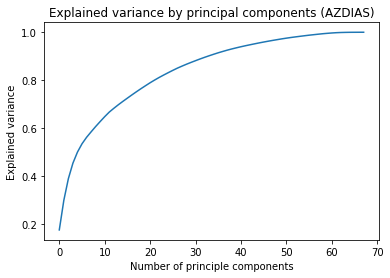

In [28]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')

plt.show()

In [29]:
# Re-apply PCA to the data while selecting for number of components to retain.

def reduce_dimension(df, n): 
    
    pca = PCA(n_components=n)
    
    df = pca.fit_transform(df)
    df = pd.DataFrame(df)
    
    print(f'Explained data variance by top {n} principal components is equal to ' 
          , np.round(pca.explained_variance_ratio_.sum(), 2)) 
    
    return pca, df


Explained data variance by top 24 principal components is equal to  0.82


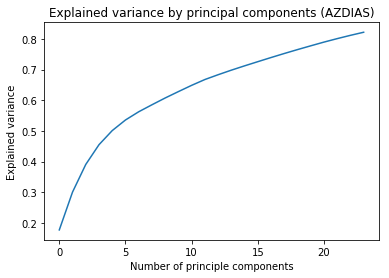

In [30]:
pca_azdias, azdias_pca_24 = reduce_dimension(azdias_ss, 24)

plt.plot(np.cumsum(pca_azdias.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')

plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

The above graphs show that 82 % of the variance is explained by the top 24 components. However we can still reduce the number of components, but paying attention to keep the rigth number in order to avoid worst accuracy score of the machine learning algorithm on the final dataset.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [31]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_features(df, pca, i):
    """ This fuction Map weights for the first principal components to corresponding feature names
        and then print the linked values, sorted by weight. """
    
    weights_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    feature_weights = weights_df.iloc[i].sort_values(ascending=False)
    
    top_po_corr = feature_weights[:4]
    top_ne_corr = feature_weights[-4:]
    top_features = top_po_corr.append(top_ne_corr)
    return top_features

In [32]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1_features = pca_features(azdias_ss, pca, 0)
pc1_features


HH_EINKOMMEN_SCORE              0.206446
CAMEO_DEUG_2015                 0.204998
CAMEO_INTL_2015_WEALTH_LEVEL    0.201463
PLZ8_BAUMAX                     0.192877
FINANZ_MINIMALIST              -0.213469
MOBI_REGIO                     -0.223535
LP_STATUS_GROB                 -0.229801
LP_STATUS_FEIN                 -0.231657
Name: 0, dtype: float64

In [33]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_features = pca_features(azdias_ss, pca, 1)
pc2_features


ALTERSKATEGORIE_GROB    0.255660
SEMIO_ERL               0.245387
FINANZ_VORSORGER        0.233298
SEMIO_LUST              0.187749
SEMIO_PFLICHT          -0.239786
SEMIO_TRADV            -0.239827
FINANZ_SPARER          -0.243819
SEMIO_REL              -0.271600
Name: 1, dtype: float64

In [34]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_features = pca_features(azdias_ss, pca, 2)
pc3_features


SEMIO_VERT    0.338564
SEMIO_SOZ     0.256904
SEMIO_FAM     0.245495
SEMIO_KULT    0.227534
SEMIO_KRIT   -0.264049
SEMIO_DOM    -0.307757
SEMIO_KAEM   -0.330486
ANREDE_KZ    -0.363969
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

#### PC1
The first principal component is most positively correlated with HH_EINKOMMEN_SCORE, CAMEO_DEUG_2015, CAMEO_INTL_2015_WEALTH_LEVEL, PLZ8_BAUMAX variables the most. Similarly, it is most negatively correlated with FINANZ_MINIMALIST, MOBI_REGIO, LP_STATUS_GROB, LP_STATUS_FEIN variables. Overall, in terms of magnitude the first principal component is most correlated with LP_STATUS_FEIN variable. However, there are no significant differences in magnitudes of other top 5 most positively and negatively correlated items. 

#### PC2
The second principal component is most positively correlated with ALTERSKATEGORIE_GROB, SEMIO_ERL, FINANZ_VORSORGER, SEMIO_LUST variables the most. Similarly, it is most negatively correlated with SEMIO_PFLICHT, SEMIO_TRADV, FINANZ_SPARER, SEMIO_REL variables. Overall, in terms of magnitude the second principal component is most correlated with SEMIO_REL variable. The second principal component seems to correlate the most with a number of attribute that correspond to individual's age related data.

#### PC3
The third principal component is most positively correlated with SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT variables the most. Similarly, it is most negatively correlated with SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ. Overall, in terms of magnitude the second principal component is most correlated with ANREDE_KZ variable. The correlation magnitudes for the outlined variables seem to vary more for the third principal component when compared to the previous two. More generally, almost all attributes that the third principal component has high correlations with seem to relate to 'personality typology' measured by affiliation to certain dimesntions like family mindedness.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [35]:
def apply_kmeans(data, n_clusters):

    """
    Calculate the average within-cluster distance given a number of cluster
    """
    
    kmeans = KMeans(n_clusters=n_clusters)
    print('Computing k = {} '.format(n_clusters))
    model = kmeans.fit(data)
    
    return np.abs(model.score(data))

In [36]:
# Over a number of different cluster counts...
avg_dist=[]
clusters=[]

for n_clusters in range(2, 25):
    clusters.append(n_clusters)
    avg = apply_kmeans(azdias_pca_24, n_clusters)
    avg_dist.append(avg)
    
    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

Computing k = 2 
Computing k = 3 
Computing k = 4 
Computing k = 5 
Computing k = 6 
Computing k = 7 
Computing k = 8 
Computing k = 9 
Computing k = 10 
Computing k = 11 
Computing k = 12 
Computing k = 13 
Computing k = 14 
Computing k = 15 
Computing k = 16 
Computing k = 17 
Computing k = 18 
Computing k = 19 
Computing k = 20 
Computing k = 21 
Computing k = 22 
Computing k = 23 
Computing k = 24 


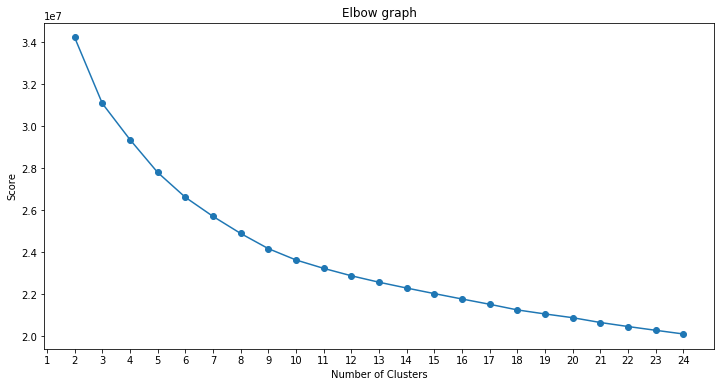

In [37]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(12,6))
plt.plot(clusters, avg_dist, marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.xticks(list(range(1,25)))
plt.title('Elbow graph')

plt.show()

In [38]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)

In [39]:
azdias_clusters = kmeans.fit_predict(azdias_pca_24)

In [40]:
azdias_clusters

array([0, 1, 5, ..., 9, 4, 9], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

The elbow method was used in order to determine the best k for the k-means clustering.From the elbow graph, we can see that there is no clear elbow in the plot. The average distances drops significantly until around 10 clusters. After k=10 the decrease in the score gets constant. So we can keep 10 as the elbow.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [41]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [42]:
# Apply preprocessing, feature transformation, and clustering from the general
customers=clean_data(customers)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149234 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 94566 non-null float64
ALTERSKATEGORIE_GROB     149234 non-null int64
ANREDE_KZ                149234 non-null int64
CJT_GESAMTTYP            146025 non-null float64
FINANZ_MINIMALIST        149234 non-null int64
FINANZ_SPARER            149234 non-null int64
FINANZ_VORSORGER         149234 non-null int64
FINANZ_ANLEGER           149234 non-null int64
FINANZ_UNAUFFAELLIGER    149234 non-null int64
FINANZ_HAUSBAUER         149234 non-null int64
FINANZTYP                149234 non-null int64
GEBURTSJAHR              98192 non-null float64
GFK_URLAUBERTYP          146025 non-null float64
GREEN_AVANTGARDE         70043 non-null float64
HEALTH_TYP               142081 non-null float64
LP_LEBENSPHASE_FEIN      139164 non-null float64
LP_LEBENSPHASE_GROB      139276 non-null float64
LP_FAMILIE_FEIN          139634 non-null float64
LP_FAMILIE_GROB          139

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


outliers rows removed
Rencoding and engineering done


In [43]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149234 entries, 0 to 149233
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB            149234 non-null float64
ANREDE_KZ                       149234 non-null float64
CJT_GESAMTTYP                   149234 non-null float64
FINANZ_MINIMALIST               149234 non-null float64
FINANZ_SPARER                   149234 non-null float64
FINANZ_VORSORGER                149234 non-null float64
FINANZ_ANLEGER                  149234 non-null float64
FINANZ_UNAUFFAELLIGER           149234 non-null float64
FINANZ_HAUSBAUER                149234 non-null float64
FINANZTYP                       149234 non-null float64
GFK_URLAUBERTYP                 149234 non-null float64
HEALTH_TYP                      149234 non-null float64
LP_LEBENSPHASE_FEIN             149234 non-null float64
LP_LEBENSPHASE_GROB             149234 non-null float64
LP_FAMILIE_FEIN                 149234 non-null float64
LP_FAMILIE_GROB                 149234 non-null f

In [44]:
# demographics onto the customer data, obtaining cluster predictions 
customers_ss = pd.DataFrame(scaler.fit_transform(customers), columns=customers.columns)

In [45]:
customers_ss.shape

(149234, 68)

In [46]:
pca = PCA()
customers_pca = pca.fit_transform(customers_ss)

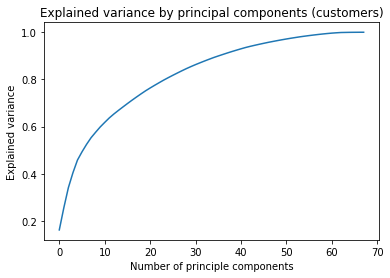

In [47]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (customers)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.show()

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_customers, customers_pca_24 = reduce_dimension(customers_ss, 24)

Explained data variance by top 24 principal components is equal to  0.8


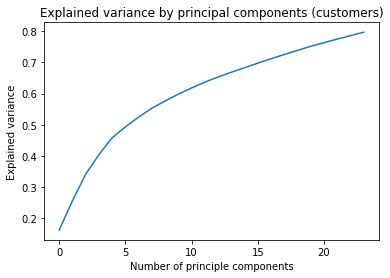

In [49]:
plt.plot(np.cumsum(pca_customers.explained_variance_ratio_))
plt.title('Explained variance by principal components (customers)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.show()

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1_features = pca_features(customers_ss, pca, 0)
pc1_features

FINANZ_HAUSBAUER                0.217184
HH_EINKOMMEN_SCORE              0.199330
CAMEO_INTL_2015_WEALTH_LEVEL    0.188047
CAMEO_DEUG_2015                 0.186942
LP_STATUS_GROB                 -0.216694
LP_STATUS_FEIN                 -0.225082
MOBI_REGIO                     -0.225102
FINANZ_MINIMALIST              -0.226371
Name: 0, dtype: float64

In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_features = pca_features(customers_ss, pca, 1)
pc2_features


FINANZ_ANLEGER          0.307244
FINANZ_SPARER           0.272148
SEMIO_KAEM              0.241213
SEMIO_RAT               0.236801
SEMIO_LUST             -0.183594
SEMIO_VERT             -0.247481
ALTERSKATEGORIE_GROB   -0.249407
FINANZ_VORSORGER       -0.255720
Name: 1, dtype: float64

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_features = pca_features(customers_ss, pca, 2)
pc3_features


SEMIO_KULT              0.285867
SEMIO_REL               0.274106
SEMIO_FAM               0.269460
SEMIO_MAT               0.199173
SEMIO_KAEM             -0.183847
ALTERSKATEGORIE_GROB   -0.195712
ANREDE_KZ              -0.237569
SEMIO_ERL              -0.275484
Name: 2, dtype: float64

In [53]:
# Over a number of different cluster counts...
avg_dist=[]
clusters=[]

for n_clusters in range(2, 25):
    clusters.append(n_clusters)
    avg = apply_kmeans(customers_pca_24, n_clusters)
    avg_dist.append(avg)

Computing k = 2 
Computing k = 3 
Computing k = 4 
Computing k = 5 
Computing k = 6 
Computing k = 7 
Computing k = 8 
Computing k = 9 
Computing k = 10 
Computing k = 11 
Computing k = 12 
Computing k = 13 
Computing k = 14 
Computing k = 15 
Computing k = 16 
Computing k = 17 
Computing k = 18 
Computing k = 19 
Computing k = 20 
Computing k = 21 
Computing k = 22 
Computing k = 23 
Computing k = 24 


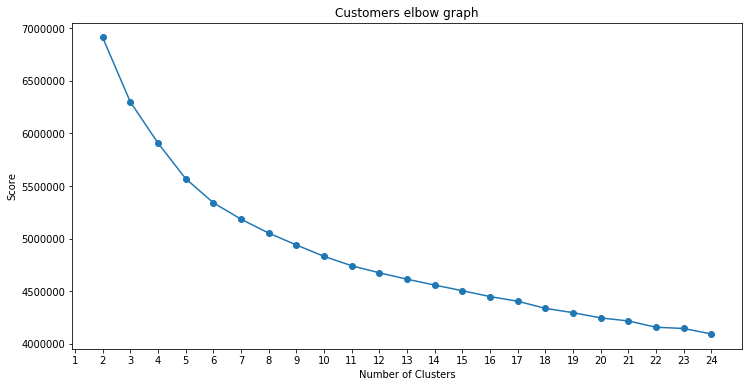

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12,6))
plt.plot(clusters, avg_dist, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(list(range(1,25)))
plt.title('Customers elbow graph')
plt.show()

In [55]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)

customers_clusters = kmeans.fit_predict(customers_pca_24)

In [56]:
customers_clusters

array([6, 2, 9, ..., 7, 1, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [58]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_clusters).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [59]:
cluster_info

,Cluster,Population,Customer
0,0,71376,16622
1,1,78313,14173
2,2,70026,17148
3,3,84238,14394
4,4,64020,8383
5,5,60754,16865
6,6,94611,16193
7,7,50431,19497
8,8,63308,10707
9,9,92378,15252


In [60]:
cluster_info['%General population'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)
cluster_info['%Customer base'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)

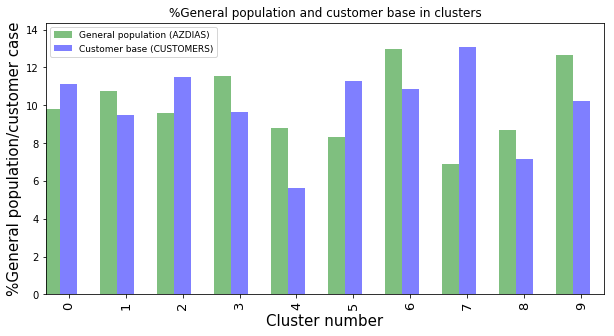

In [61]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)

ax = cluster_info['%General population'].plot(x=cluster_info['Cluster'], \
                                                  width=-0.3, align='edge', \
                                                  color='g', alpha=0.5, kind='bar', position=0)
ax = cluster_info['%Customer base'].plot(kind='bar', color='b', alpha=0.5, width = 0.3, align='edge', position=1)

ax.set_xlabel('Cluster number', fontsize=15) 
ax.set_ylabel('%General population/customer case', fontsize=15)

ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General population (AZDIAS)', 'Customer base (CUSTOMERS)'), fontsize=9)
plt.title(('%General population and customer base in clusters'))

plt.show()

In [63]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster7 = scaler.inverse_transform(pca_customers.inverse_transform(kmeans.cluster_centers_[7]))
over_represented = pd.Series(data = cluster7, index = customers.columns)
over_represented.head(3)


ALTERSKATEGORIE_GROB    3.624063
ANREDE_KZ               1.004492
CJT_GESAMTTYP           3.140574
dtype: float64

In [64]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster4 = scaler.inverse_transform(pca_customers.inverse_transform(kmeans.cluster_centers_[4]))
under_represented = pd.Series(data = cluster4, index = customers.columns)
under_represented.head(3)


ALTERSKATEGORIE_GROB    1.658295
ANREDE_KZ               1.664722
CJT_GESAMTTYP           3.523567
dtype: float64

In [65]:
# percentage of people per cluster for the general population
cluster, cluster_counts = np.unique(azdias_clusters, return_counts=True)
cluster_proportion = [int(i/cluster_counts.sum()*100) for i in cluster_counts]
percentages = np.asarray((cluster, cluster_proportion)).T
percentages

array([[ 0,  9],
       [ 1, 10],
       [ 2,  9],
       [ 3, 11],
       [ 4,  8],
       [ 5,  8],
       [ 6, 12],
       [ 7,  6],
       [ 8,  8],
       [ 9, 12]])

In [66]:
# percentage of people per cluster on customers base
cluster, cluster_counts = np.unique(customers_clusters, return_counts=True)
cluster_proportion = [int(i/cluster_counts.sum()*100) for i in cluster_counts]
percentages = np.asarray((cluster, cluster_proportion)).T
percentages

array([[ 0, 11],
       [ 1,  9],
       [ 2, 11],
       [ 3,  9],
       [ 4,  5],
       [ 5, 11],
       [ 6, 10],
       [ 7, 13],
       [ 8,  7],
       [ 9, 10]])

### Discussion 3.3: Compare Customer Data to Demographics Data

As shows the graphs above, there are significant differences in proportions of people in the general population clusters and the firm's customer clusters. Most notably the most over-represented cluster in the customer population is cluster 7 as 13% of customers fit in this cluster while 6% of the general population fits in this cluster. Reversing the data transformations it on this cluster center it is clear that the majority of the firm's customers are 46 - 60 years old, male, and advertising when considering the first 3 attributes of the dataset ALTERSKATEGORIE_GROB, ANREDE_KZ and CJT_GESAMTTYP respectively. Alternatively, cluster 4 accounts for less than 5% of the customers while there are 8% of people in the same cluster in the general population. Considering the same first three attributes, on average, individuals that are between 30 - 45 years old, female .